In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import scipy.stats
import numpy as np

/Users/david.fischer/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Generate some data:

In [2]:
from batchglm.api.models.nb_glm import Simulator

sim = Simulator(num_observations=2000, num_features=100)
sim.generate_sample_description(num_batches=4, num_confounders=0)
# sample parameters from positive truncated N(1, 0.1)
mu=1; phi=0.1
sim.generate_params(rand_fn_loc=lambda size: mu + scipy.stats.truncnorm.rvs(-mu / phi, np.infty, scale=phi, size=size))
sim.generate_data()

# count data
X = sim.X
# sample description
sample_description = sim.sample_description

The sample description should be a pandas DataFrame with `num_observations` rows.
Each column should represent a property of the dataset.

The module `batchglm.api.data` contains some helper functions which can be useful to create this sample description:

- `sample_description_from_anndata()`
- `sample_description_from_xarray()`

In [3]:
sample_description.iloc[:10,:]

,batch
observations,
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0


# Run differential expression test:

The pairwise test allows to perform pairwise comparisons between a set of groups.

It needs a parameter `grouping` which assigns a group to each sample.
This `grouping` can either be a vector of length `num_observations` or a string specifying a column in the sample description.
Since we simulated `grouping` with `num_batches=4` different groups, the pairwise test will perform $\frac{n*(n-1)}{2} = 6$ different tests.

The parameter `test` specifies which kind of statistical test will be performed for each pair of groups.
Possible arguments are all `two_sample` tests (e.g. 'wald', 't-test', 'wilcoxon', ...) and 'z-test'.
The 'z-test' is a special kind of test which treats each group as a coefficient in a single linear model and therefore requires fitting only one GLM for all tests. This significantly reduces the runtime compared to the 'wald'-test.

In [10]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

import diffxpy.api as de

test = de.test.pairwise(
    data=X,
    grouping="batch",
    test="z-test",
    noise_model="nb",
    sample_description=sample_description
)


# Obtaining the results

The p-/q-values can be obtained by calling `test.pval` / `test.qval`:

In [11]:
np.set_printoptions(precision=3)
print("shape of p-values: %s" % str(test.pval.shape))

shape of p-values: (4, 4, 100)


p-values of first gene:

In [12]:
test.pval[:,:,0]

array([[0.000e+00, 1.264e-02, 6.950e-02, 1.432e-01],
       [1.264e-02, 0.000e+00, 7.370e-01, 1.044e-05],
       [6.950e-02, 7.370e-01, 0.000e+00, 1.282e-03],
       [1.432e-01, 1.044e-05, 1.282e-03, 0.000e+00]])

test.summary() returns a pandas DataFrame with a quick overview of the test results:

In [13]:
test.summary().iloc[:10,:]

,gene,pval,qval,log2fc,mean
0,0,0.0,0.0,-0.403161,6096.385
1,1,0.0,0.0,-0.118499,4917.605
2,2,0.0,0.0,-0.616354,2587.940
3,3,0.0,0.0,-0.322211,2107.085
4,4,0.0,0.0,-0.703069,2336.015
5,5,0.0,0.0,0.226066,4206.020
6,6,0.0,0.0,-0.261588,5030.805
7,7,0.0,0.0,-0.672430,3449.830
8,8,0.0,0.0,0.687060,7750.230
9,9,0.0,0.0,-0.622070,6079.460


- `gene`: gene name / identifier
- `pval`: minimal p-value of the tests
- `qval`: minimal multiple testing - corrected p-value of the tests
- `log2fc`: maximal $log_2$ fold change of the tests

`test.plot_volcano()` creates a volcano plot of p-values vs. fold-change:

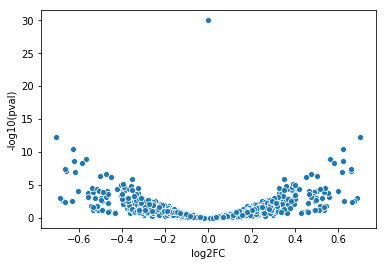

In [14]:
test.plot_volcano()
plt.show()

`test.plot_diagnostics()` is a shortcut to directly show all diagnostics plots.

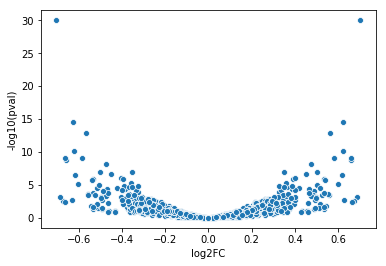

In [9]:
test.plot_diagnostics()